# Let's flow some tensors for multi class logistic regression

In [1]:
import tensorflow as tf # need to import the right package
import numpy as np 

/home/pooran/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters



Here we will build a simple logistic regression model to classify mnist data set

Task: **classify the hadwritten digit label $\in \{1, 2, \cdots, 9 \}$ using pixel from the digit image.**

This is classification(discrete label output) problem and multi class logistic regression can be used here

Check   [Yann LeCun](http://yann.lecun.com/),      http://yann.lecun.com/exdb/mnist/  website for details about mnist dataset etc.



In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


## Verify everthing looks good

In [3]:
print('{} training example with shape {}'.format(mnist.train.num_examples, mnist.train.images[0].shape))
print('{} test example with shape {}'.format(mnist.test.num_examples, mnist.test.images[0].shape))
mnist.train.images.shape

55000 training example with shape (784,)
10000 test example with shape (784,)


(55000, 784)

Dataset contains 55000 training and 10000 test example for handwritten digits in vectorized form(take pixel along rows and stack them in a column vector).

Images are 28X28 gray scale. After vectrorization we have 784 dimentional vector

In [4]:
28*28 == 784

True

## Let's do some sanity check

In [5]:

NUM_CLASSES = 10
X_DIM = 28
Y_DIM = 28
import numpy as np
unique_label = np.unique(np.argmax(mnist.train.labels, 1))
print(unique_label)
assert NUM_CLASSES == len(unique_label), 'number of label does not match'
assert X_DIM*Y_DIM == mnist.train.images[0].size, 'total pixel does not match'

[0 1 2 3 4 5 6 7 8 9]


## Let's randomly view some of them

In [6]:
# magic command so that images are inline in notebook
%matplotlib inline 
import matplotlib.pyplot as plt # visualization package in python

[ 2732 43567 42613 52416 45891 21243 30403 32103 41993 20757 46884 14935
 15430 48600 39512 52620]


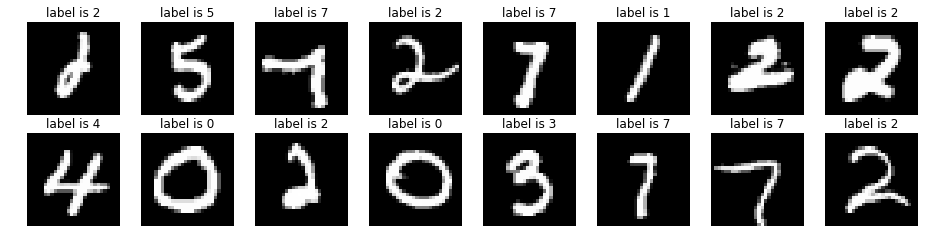

In [7]:
np.random.seed(0) # to make sure we have deterministic results on each iteration
NUM_FIG_DISP = 16
nrow = NUM_FIG_DISP//2
ncol = NUM_FIG_DISP//2
rand_ind = np.random.randint(mnist.train.num_examples, size=NUM_FIG_DISP)
print(rand_ind)
plt.figure(1,figsize= (16, 16))
plt.gray()
for idx, image_index in enumerate(rand_ind):
    plt.subplot(nrow,ncol,idx +1)
    # Have to reshape to 28x28 for display
    plt.imshow(np.reshape(mnist.train.images[image_index], (X_DIM, Y_DIM)) )
    plt.title('label is {}'.format(np.argmax(mnist.train.labels[image_index])))  
    plt.axis('off')
plt.show()

## define  multi class logistic regression  model

### Remember for each class $c \in \{1, 2, \cdots, K= 10   \}$ we need to compute

 probablity
 <font size = 6>
 $P(y = c|x) = \frac{\exp(w_{oc} + w_c^Tx)}{\sum_i^K \exp(w_{oi} + w_i^Tx) }$
 </font>
 
 
 Note the one can either add 1 to features or work with $D+1$ dimentional features or add class bias $w_{oc}$ term for each class explicility as done in above formula.
 
 We can keep each weight vector $[w_{c}]_{D \times 1}$ in $D\times K$ matrix $W$, 
 $$W = {\begin{bmatrix} w_1, w_2, \cdots, w_K \end{bmatrix}}_{D \times K}$$
 
 and class biases  in vector  $W_o = {\begin{bmatrix} w_{o1}\\ w_{02} \\ \vdots \\ w_{0K} \end{bmatrix}}_{K \times 1}$. $D$ is data dimension.
 
 
 Using matrix operation we can calculate each class probability for given example $x_{784 \times 1}$ by doing
 
 $softmax(W_o +  W^T x)$ where 
 
 $$W_o + W^Tx = \begin{bmatrix} w_{o1}\\ \vdots \\ w_{oK} \end{bmatrix} + \begin{bmatrix}  w_1^T\\ \vdots \\  w_K^T \end{bmatrix} x = \begin{bmatrix}w_{01} + w_1^Tx\\ \vdots \\ w_{0K} + w_K^Tx \end{bmatrix}$$
 
 Also remember that 
 <font size = 5>
 
 $$softmax(\begin{bmatrix} z_1 \\ z_2 \\ \vdots \\ z_K  \end{bmatrix}) = \begin{bmatrix} \frac{\exp(z_1)}{\sum_i^K \exp(z_i)} \\ \frac{\exp(z_2)}{\sum_i^K \exp(z_i)} \\ \vdots \\ \frac{\exp(z_K)}{\sum_i^K \exp(z_i)}  \end{bmatrix} $$ </font>
 
 Convince yourself that after applying softmax we will get the formula at the beginning of the cell.

# Let's try to  code above equations using tensorflow computational graph

In [8]:
PIXELS_PER_SAMPLE = X_DIM*Y_DIM

X =  tf.placeholder(tf.float32, [None, PIXELS_PER_SAMPLE])
Y = tf.placeholder(tf.float32, [None, NUM_CLASSES])

print(X.shape, Y.shape)
with tf.variable_scope("multi_class_logistic_model", reuse=tf.AUTO_REUSE):
    W = tf.get_variable('Weight_matrix', initializer = tf.random_normal(shape = (X_DIM*Y_DIM, NUM_CLASSES)))    
    W_o= tf.get_variable('class_bias_vector',  initializer = tf.zeros(shape = (NUM_CLASSES,1)))
    print(X.shape, W.shape, W_o.shape)
    # we have to do X traspose as examples are along the row and we need them along columns

    Y_pred = tf.matmul(tf.transpose(W), tf.transpose(X))  + W_o
    
print('shape of prediction vector is {}'.format(Y_pred.shape))


(?, 784) (?, 10)
(?, 784) (784, 10) (10, 1)
shape of prediction vector is (10, ?)


# ? represent free dimension so let transpose it again to keep free dimention first

In [9]:

Y_pred = tf.transpose(Y_pred)
print('shape of prediction vector is {}'.format(Y_pred.shape))

shape of prediction vector is (?, 10)




<font color = "red">Also above code can we written(most of the time you will see tensorflow code other way around) without so much transpose operations but then we have to think of above equations in transpose sense </font> 

It doesn't matter how you keep examples/weight in matrix(row or columns fashion). Just be careful about interpretation.

## Let's convert this score vector of 10 into probability vector using softmax

In [10]:
Y_pred_prob = tf.nn.softmax(Y_pred)

## build a loss/cost/objective function to measure how good we are doing

We use cross entopy as discussed in the class

In [11]:
loss = tf.reduce_mean(-Y*tf.log(Y_pred_prob))

## build an accuracy measure

In [12]:
accuracy = tf.equal(tf.argmax(Y,1), tf.argmax(Y_pred_prob,1)) # picking the index of high probabiity
accuracy = tf.cast(accuracy, tf.float32)
accuracy = tf.reduce_mean(accuracy)

In [13]:
accuracy.get_shape()

TensorShape([])

## let create an optimizer

Remember some time there is no close form solution to find parameters $W$ which maximizes likelihood or log likelihood function $C(W)$ (**MLE estimation procedure**) as in logistic regression. We showed that if function $C(W)$  is differentiable
one can use an iterative procedure called **gradient descent(GD)** to update the parameters.

$W_{k+1} = W_k + \eta \frac{dC(W)}{W}$

where $C(W) = \sum_{i=1}^{N}$cross_entropy(true_probability_i, machine_predicted_probability_i)

- To update parameter we have to compute $C(W)$ for all the example at every step. This can be
computationalty expensive if we have millions of example

One extreme is shuffle all the example and use one example(cost/loss of one example) at a time. This is called

**Stochastic GD**
for i in range(N):
    $W_{k+1} = W_k + \eta \frac{dC(W)_i}{W}$
    
As you can guess with this approach our search path for parameter search can be quite noisy. There are lot of other mathematical questions we need to ask,
- like will learned parameters  be correct?
- Will cost decrease or not?

In short there are gurantees if cost function is convex.

We can take a midway approach called **Mini-batch gradient**, where we use small portion of total example at each step to update the parameters $W$

Lingo we need to get used to is 

- size of Mini-batch is called batch size
- As you can guess we are not using all the example in each iteration/step, hence we need to make multiple
  iteration of batch size so that optimization alogorithm has seen all the example.
- An Epoch is a complete pass through all the training data. An Epcoh will contain multiple iteration of batch size examples
- We use multiple pass through training examples(epoch) to learn value of parameter $W$. Also we need to shuffle examples at each new epoch.

    
    

In [14]:
opt = tf.train.GradientDescentOptimizer(learning_rate = .25).minimize(loss)
#opt= tf.train.AdamOptimizer(learning_rate = .0001).minimize(loss)

In [15]:
print(mnist.train.images[0].dtype)
print(mnist.train.labels[0].dtype)

float32
float64


In [16]:
BATCH_SIZE = 100
NUM_EPOCHS = 20

## Lets run the model and see how it performing

Note here I am using test data as validation data here.

In [17]:
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for eidx in range(NUM_EPOCHS):
        epoch_acc, epoch_loss = [], []
        for bidx in range(mnist.train.num_examples// BATCH_SIZE):
            xs, ys = mnist.train.next_batch(BATCH_SIZE)
            xs = xs.astype(np.float32)
            _, train_loss, train_acc= sess.run([opt, loss, accuracy], feed_dict={X:xs, Y:ys})
            if (bidx+1)%100 == 0: # print result every 100 batch
                print('epoch {} training batch {} loss {} accu {}'.format(eidx +1 , bidx +1, train_loss, train_acc))
            epoch_acc.append(train_acc)
            epoch_loss.append(train_loss)
        print('##################################')
        val_acc, val_loss = sess.run([accuracy, loss],
            feed_dict= {X:mnist.test.images.astype(np.float32), Y: mnist.test.labels})
        print('epoch {} # test accuracy {} $ test loss {}'.format(eidx +1, val_acc, val_loss ))
        print('##################################') 
        # Let keep epoch level values for plotting
        train_losses.append(np.mean(epoch_loss))
        train_accuracies.append(np.mean(epoch_acc))
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
                

epoch 1 training batch 100 loss 0.9014299511909485 accu 0.1599999964237213
epoch 1 training batch 200 loss 0.5916724801063538 accu 0.23000000417232513
epoch 1 training batch 300 loss 0.4246673882007599 accu 0.38999998569488525
epoch 1 training batch 400 loss 0.3494284451007843 accu 0.49000000953674316
epoch 1 training batch 500 loss 0.3085678815841675 accu 0.47999998927116394
##################################
epoch 1 # test accuracy 0.5232999920845032 $ test loss 0.28506243228912354
##################################
epoch 2 training batch 100 loss 0.3459147810935974 accu 0.44999998807907104
epoch 2 training batch 200 loss 0.28825122117996216 accu 0.5400000214576721
epoch 2 training batch 300 loss 0.24310171604156494 accu 0.6000000238418579
epoch 2 training batch 400 loss 0.23807105422019958 accu 0.5899999737739563
epoch 2 training batch 500 loss 0.16303911805152893 accu 0.6800000071525574
##################################
epoch 2 # test accuracy 0.6689000129699707 $ test loss 0.1811

epoch 17 training batch 100 loss 0.044700540602207184 accu 0.8600000143051147
epoch 17 training batch 200 loss 0.09818822890520096 accu 0.8700000047683716
epoch 17 training batch 300 loss 0.062140293419361115 accu 0.8399999737739563
epoch 17 training batch 400 loss 0.042425736784935 accu 0.9200000166893005
epoch 17 training batch 500 loss 0.05146167799830437 accu 0.8899999856948853
##################################
epoch 17 # test accuracy 0.8533999919891357 $ test loss 0.0711313784122467
##################################
epoch 18 training batch 100 loss 0.13185352087020874 accu 0.7900000214576721
epoch 18 training batch 200 loss 0.07781290262937546 accu 0.8199999928474426
epoch 18 training batch 300 loss 0.06983955949544907 accu 0.8299999833106995
epoch 18 training batch 400 loss 0.04688161239027977 accu 0.8799999952316284
epoch 18 training batch 500 loss 0.08633913844823837 accu 0.8299999833106995
##################################
epoch 18 # test accuracy 0.8561999797821045 $ test

In [18]:
#len(val_losses)
train_accuracies


[0.31429088,
 0.58718187,
 0.6819091,
 0.7284,
 0.7568546,
 0.7749637,
 0.7892909,
 0.80018175,
 0.8089455,
 0.8156727,
 0.8212364,
 0.82623637,
 0.83036363,
 0.8343273,
 0.8378,
 0.8401819,
 0.8437818,
 0.84652734,
 0.84810907,
 0.8505454]

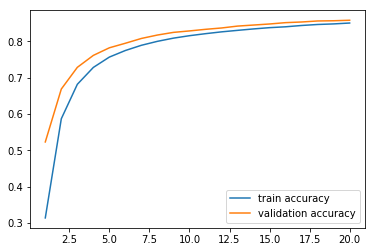

In [19]:
plt.plot(range(1, NUM_EPOCHS+1),  train_accuracies)
plt.plot(range(1, NUM_EPOCHS+1),  val_accuracies)
plt.legend(['train accuracy','validation accuracy'])
plt.show()

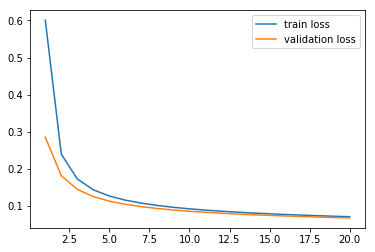

In [20]:
plt.plot(range(1, NUM_EPOCHS+1),  train_losses)
plt.plot(range(1, NUM_EPOCHS+1),  val_losses)
plt.legend(['train loss','validation loss'])
plt.show()

# In deep leaning section we will beat current accuracy numbers